In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import jax
import jax.numpy as jnp

In [2]:
df = pd.read_csv("optim_evaluation.csv", index_col=0)

df.insert(10, "AR", df["b"]/df["c"])

df.head()

,lift_goal,v_infty,altitude,alpha_geo,B,T,P,C,E,R,AR,b,c,L,D,time
0,9999.994,95.598816,1065.2062,3.432269,1.766099,0.166530,2.960293,1.182179e-02,0.995304,0.017997,7.055989,7.055989,1.0,10032.12804,296.515528,13.089736
1,9999.994,108.808140,3246.1655,0.734761,1.699920,0.162388,2.834756,2.430560e-02,0.965241,0.014733,7.753572,7.753572,1.0,10033.78567,209.603014,67.353632
2,9999.994,157.776700,7765.6600,0.752891,1.754575,0.175176,2.932717,2.660000e-17,0.989982,0.000220,7.161887,7.161887,1.0,10031.71461,280.453419,28.736861
3,9999.994,235.891110,4487.9290,1.628609,1.717111,0.198824,2.865658,1.986873e-02,0.982212,0.018517,5.000000,5.000000,1.0,13027.43611,423.632064,27.914546
4,9999.994,119.611970,2060.0298,5.206943,1.707645,0.157157,2.843198,7.330540e-03,0.964584,0.019820,5.000000,5.000000,1.0,13696.30558,520.709182,11.009721


In [3]:
df.insert(14, "lift_error", (df["L"] - df["lift_goal"]).abs() / df["lift_goal"])
cleaned_df = df.query("lift_error <= 0.05")

cleaned_df.head()

,lift_goal,v_infty,altitude,alpha_geo,B,T,P,C,E,R,AR,b,c,L,lift_error,D,time
0,9999.994,95.598816,1065.2062,3.432269,1.766099,0.166530,2.960293,1.182179e-02,0.995304,0.017997,7.055989,7.055989,1.000000,10032.128040,0.003213,296.515528,13.089736
1,9999.994,108.808140,3246.1655,0.734761,1.699920,0.162388,2.834756,2.430560e-02,0.965241,0.014733,7.753572,7.753572,1.000000,10033.785670,0.003379,209.603014,67.353632
2,9999.994,157.776700,7765.6600,0.752891,1.754575,0.175176,2.932717,2.660000e-17,0.989982,0.000220,7.161887,7.161887,1.000000,10031.714610,0.003172,280.453419,28.736861
8,9999.994,50.435795,9991.7950,0.138556,1.673423,0.150000,2.788321,2.372530e-02,0.947188,0.005107,14.931614,24.551570,1.644268,9931.072314,0.006892,177.177007,21.886007
11,9999.994,142.049530,8529.5130,2.093887,1.752473,0.189927,2.926725,1.161523e-02,0.998886,0.013842,7.817631,7.817631,1.000000,10031.147060,0.003115,267.405345,10.648830


In [4]:
lift_goal = df["lift_goal"]

#Lift of unique lift goals
lift_goals = jnp.array(lift_goal)[::20]

In [5]:
def batch_by_lift(df, column):
    total = []
    for goal in lift_goals:
        filtered = df[df["lift_goal"] == goal]
        total.append(jnp.array(filtered[column]).mean())
        
    return jnp.array(total)

Average Lift Error: 0.04195215


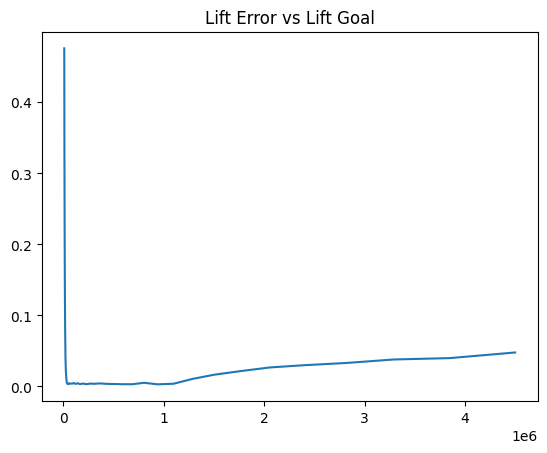

In [6]:
#Batch the lift errors
lift_errors = batch_by_lift(df, "lift_error")

print("Average Lift Error:", lift_errors.mean())

#Plot errors against the lift goals
plt.title("Lift Error vs Lift Goal")
plt.plot(lift_goals, lift_errors);

Average Lift Error: 0.0037151934


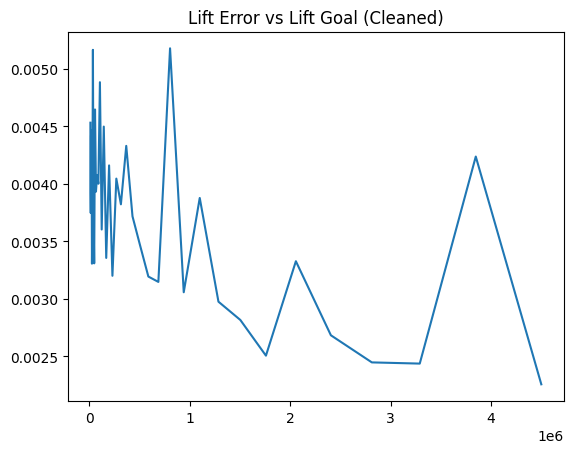

In [7]:
#Batch the lift errors
lift_errors = batch_by_lift(cleaned_df, "lift_error")

print("Average Lift Error:", lift_errors.mean())

#Plot errors against the lift goals
plt.title("Lift Error vs Lift Goal (Cleaned)")
plt.plot(lift_goals, lift_errors);

Average L/D Ratio: 38.431927


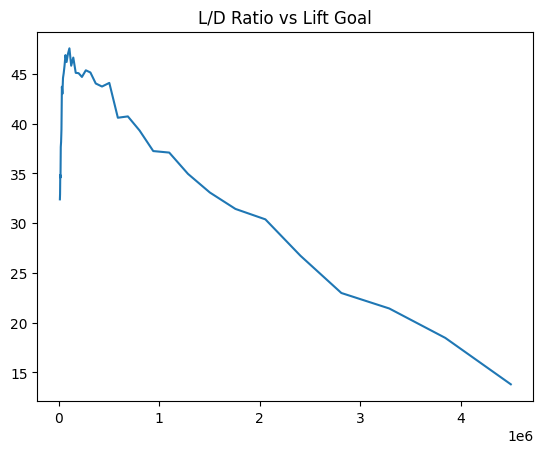

In [8]:
df.insert(14, "LD_ratio", df["L"]/ df["D"])

LD_ratio = batch_by_lift(df, "LD_ratio")

print("Average L/D Ratio:", LD_ratio.mean())

plt.title("L/D Ratio vs Lift Goal")
plt.plot(lift_goals, LD_ratio);

Average L/D Ratio: 39.456314


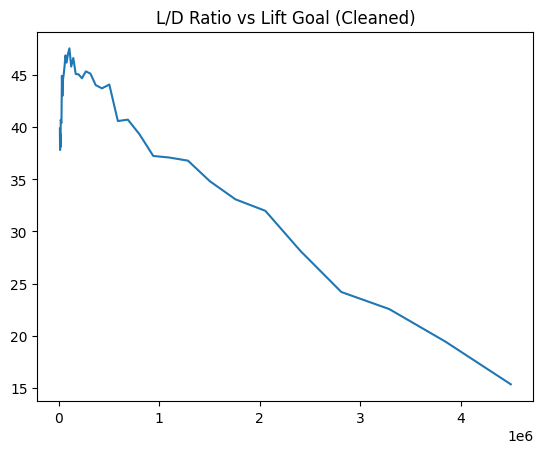

In [9]:
cleaned_df.insert(14, "LD_ratio", df["L"]/ df["D"])

LD_ratio = batch_by_lift(cleaned_df, "LD_ratio")

print("Average L/D Ratio:", LD_ratio.mean())

plt.title("L/D Ratio vs Lift Goal (Cleaned)")
plt.plot(lift_goals, LD_ratio);

Average optimization time: 30.242329


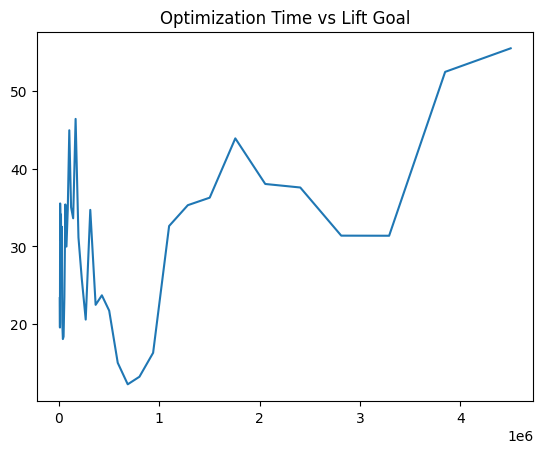

In [10]:
times = batch_by_lift(df, "time")

print("Average optimization time:", times.mean())

plt.title("Optimization Time vs Lift Goal")
plt.plot(lift_goals, times);

Average optimization time: 22.91597
Average optimization time: 8.832277


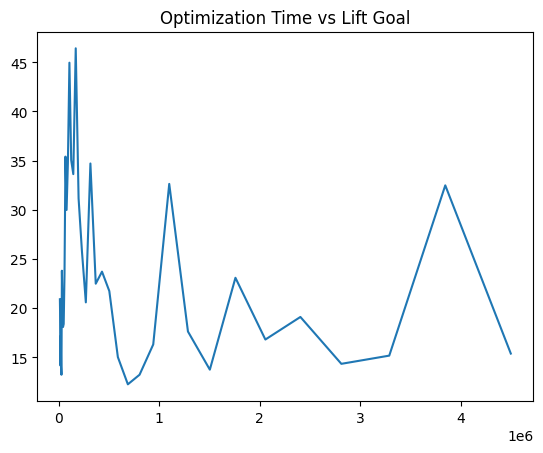

In [15]:
times = batch_by_lift(cleaned_df, "time")

print("Average optimization time:", times.mean())
print("Standard Deviation:", times.std())


plt.title("Optimization Time vs Lift Goal")
plt.plot(lift_goals, times);

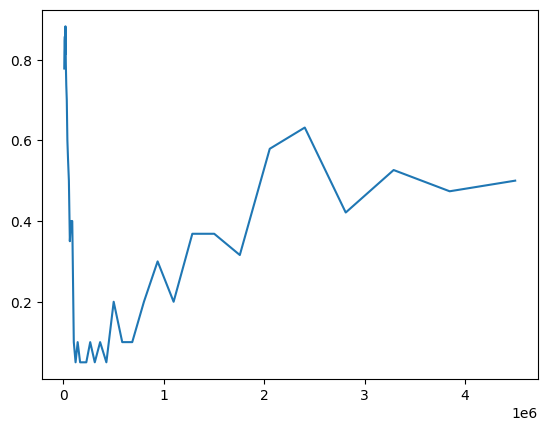

In [12]:
#Bounds checking
dv_bounds = {
    "B": (1.5, 1.8),
    "T": (0.15, 0.25),
    "P": (2.5, 3.5),
    "C": (0, 0.75),
    "E": (0.6, 1),
    "R": (-0.02, 0.02),
    "c": (1, 4),
    "AR": (5, 15)
}

df = cleaned_df.copy()

dv_name = "c"

#Mask dataframe to see if DV matches bounds
masked_df = (df[dv_name] == dv_bounds[dv_name][0]) | (df[dv_name] == dv_bounds[dv_name][1])

#Convert bools to ints
masked_arr = jnp.array(masked_df, dtype=jnp.int32)

df.insert(0, "boundary_hit", masked_arr)

#Find amount of times boundary hit for each lift goal
boundary_hits = batch_by_lift(df, "boundary_hit")

plt.plot(lift_goals, boundary_hits);